In [1]:
%load_ext autoreload
import torch

import sys

sys.path.append("../..")
from mlstm_kernels.utils.test.checks import verify_output
from mlstm_kernels.torch.utils import to_numpy
from tests.torch.losses_tests import loss_layernorm_offset_quadratic

torch.set_printoptions(linewidth=200)

In [2]:
%autoreload 2
from mlstm_kernels.torch.parallel.native_stablef import (
    mlstm_parallel__native_stablef_autograd,
)
from mlstm_kernels.torch.chunkwise.native import mlstm_chunkwise__native_custbw
from mlstm_kernels.torch.chunkwise.native.bw import (
    mlstm_chunkwise__recurrent_bw_dC as mlstm_cw_rec_bw_dC_native,
)
from mlstm_kernels.torch.chunkwise.triton_xl_chunk import mlstm_chunkwise__xl_chunk
from mlstm_kernels.torch.chunkwise.triton_xl_chunk.bw_recurrent import (
    mlstm_chunkwise__recurrent_bw_dC as mlstm_cw_rec_bw_dC_xl_chunk,
)

# Debugging of xl_chunk size backward kernel for deltaC

Bug description:

The gradient for the deltaC states (not for dC_0 and dC_last) are wrong when the (inter) chunk size for the backward dC kernel (referred to as bw_dC_CS) does not match the total chunk size (referred to as TCS). In other words when there happens accumulation in the loop when save_every_nth_chunk is larger than 1. 

Cases:
- bw_dC_CS == TCS: correct
- bw_dC_CS < TCS: intermediate states are wrong, but the first state C_0 at the end of the loop is correct.



In [3]:
seed = 1
B = 1
NH = 1
S = 128
DHQK = 16
DHHV = 16
device = torch.device("cuda:0")
dtype = torch.float32

vecI_offset = 0.0
vecF_offset = 3.0

In [4]:
torch.manual_seed(seed)
matQ = torch.randn((B, NH, S, DHQK), dtype=torch.float32, device=device)
matK = torch.randn((B, NH, S, DHQK), dtype=torch.float32, device=device)
matV = torch.randn((B, NH, S, DHHV), dtype=torch.float32, device=device)
vecI = vecI_offset + torch.randn((B, NH, S), dtype=torch.float32, device=device)
vecF = vecF_offset + torch.randn((B, NH, S), dtype=torch.float32, device=device)

baseline_dtype = dtype
matQ_baseline = matQ.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
matK_baseline = matK.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
matV_baseline = matV.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
vecI_baseline = vecI.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)
vecF_baseline = vecF.clone().to(dtype=baseline_dtype).detach().requires_grad_(True)

target_dtype = dtype
matQ_target = matQ.clone().to(dtype=target_dtype).detach().requires_grad_(True)
matK_target = matK.clone().to(dtype=target_dtype).detach().requires_grad_(True)
matV_target = matV.clone().to(dtype=target_dtype).detach().requires_grad_(True)
vecI_target = vecI.clone().to(dtype=target_dtype).detach().requires_grad_(True)
vecF_target = vecF.clone().to(dtype=target_dtype).detach().requires_grad_(True)

In [5]:
for cs in [16, 32, 64, 128]:  # [64, 128, 256, 512, 1024]:
    matH_bl, _ = mlstm_chunkwise__native_custbw(
        matQ_baseline,
        matK_baseline,
        matV_baseline,
        vecI_baseline,
        vecF_baseline,
        return_last_states=True,
        chunk_size=cs,
    )
    loss_layernorm_offset_quadratic(matH_bl).backward()

Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs16.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs32.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs64.pt
Saved inputs to /home/max/myrepos/nxai_public/mlstm_kernels_internal_cleaned/notebooks_kernel_dev/xl_chunk/debug_xl_chunk_bw_dC_inputs_cs128.pt


In [6]:
inputs = torch.load("debug_xl_chunk_bw_dC_inputs_cs64.pt")

In [7]:
mQ_bl = inputs["matQ"]
vB_bl = inputs["vecB"]
vF_bl = inputs["vecF"]
sM_bl = inputs["scaM_inter"]
vMc_bl = inputs["vecM_combine"]
mDH_bl = inputs["matDeltaH"]
vNo_bl = inputs["vecN_out"]
mDCl_bl = inputs["matDeltaC_last"]
num_chunks = inputs["NUM_CHUNKS"]
eps = inputs["EPS"]
chunk_size = inputs["CHUNK_SIZE"]
print(f"chunk_size: {chunk_size}, num_chunks: {num_chunks}, eps: {eps}")
print(
    f"matQ shape: {mQ_bl.shape}, vecB shape: {vB_bl.shape}, vecF shape: {vF_bl.shape}, sM shape: {sM_bl.shape}, vMc shape: {vMc_bl.shape}, mDH shape: {mDH_bl.shape}, vNo shape: {vNo_bl.shape}, mDCl shape: {mDCl_bl.shape}"
)
matDeltaC_states_gt = inputs["matDeltaC_states"]
# vF_bl = 25. * torch.ones_like(vF_bl)  # scale vecF for testing purposes
mDC_comp_bl = mlstm_cw_rec_bw_dC_native(
    matQ=mQ_bl,
    vecB=vB_bl,
    scaM_inter=sM_bl,
    vecM_combine=vMc_bl,
    matDeltaH=mDH_bl,
    vecN_out=vNo_bl,
    matDeltaC_last=mDCl_bl,
    qk_scale=None,
    num_chunks=num_chunks,
    eps=eps,
    chunk_size=chunk_size,
)
print(f"mDC_comp_bl shape: {mDC_comp_bl.shape}")

chunk_size: 64, num_chunks: 2, eps: 9.999999974752427e-07
matQ shape: torch.Size([1, 1, 128, 16]), vecB shape: torch.Size([1, 1, 2, 64]), vecF shape: torch.Size([1, 1, 2, 64]), sM shape: torch.Size([1, 1, 3]), vMc shape: torch.Size([1, 1, 128]), mDH shape: torch.Size([1, 1, 128, 16]), vNo shape: torch.Size([1, 1, 128]), mDCl shape: torch.Size([1, 1, 16, 16])
mDC_comp_bl shape: torch.Size([1, 1, 48, 16])


In [8]:
mdC_comp_tgt = mlstm_cw_rec_bw_dC_xl_chunk(
    matQ=mQ_bl,
    vecF=vF_bl,
    scaM_inter=sM_bl,
    vecM_combine=vMc_bl,
    matDeltaH=mDH_bl,
    vecN_out=vNo_bl,
    matDeltaC_last=mDCl_bl,
    qk_scale=None,
    chunk_size=32,  # chunk_size,
    save_states_every_nth_chunk=2,  # 1,
    eps=eps,
)
mdC_comp_tgt.shape

num_chunks_saved: 2
matDeltaC_states shape: torch.Size([1, 1, 48, 16])
grid shape: (1, 1, 1)


torch.Size([1, 1, 48, 16])

pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0, 0) idx () idx_k: 4
pid (0, 0,

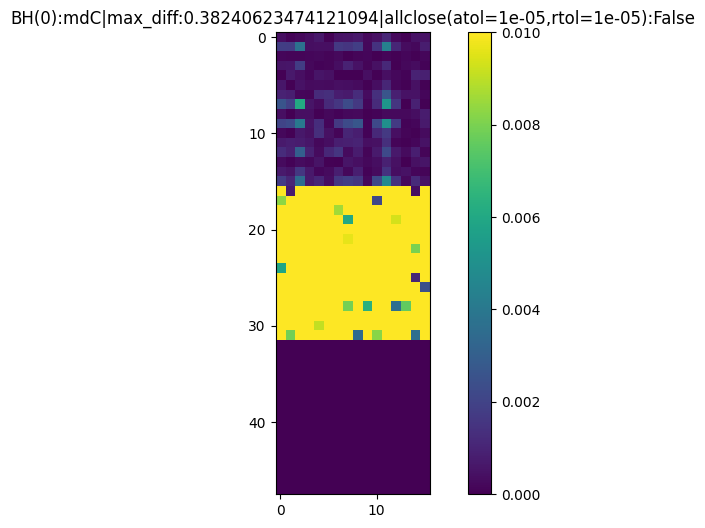

In [9]:
fig = verify_output(
    "mdC", to_numpy(mDC_comp_bl), to_numpy(mdC_comp_tgt), atol=1e-5, rtol=1e-5
)

In [27]:
inputs32cs = torch.load("debug_xl_chunk_bw_dC_inputs_cs32.pt")
mdc_32cs = inputs32cs["matDeltaC_states"]
mdc_32cs.shape

torch.Size([1, 1, 80, 16])

In [10]:
k = 4
mdc_32cs[:, :, (k - 1) * (16) : (k) * (16), :]

tensor([[[[ 7.5953e-01,  2.9565e+00, -4.9126e-01, -1.3099e+00, -3.0082e-01, -1.1565e+00, -3.6493e-01,  1.3810e+00, -5.7462e-01,  2.5916e-01, -1.0539e+00,  8.6686e-01, -1.5464e+00, -6.4601e-01,
           -1.0760e+00,  2.2972e+00],
          [ 2.1429e+00,  1.7601e+00,  3.9552e-01, -1.9271e+00,  1.2764e+00,  6.6979e-01, -2.8664e-01, -2.2977e+00, -7.6857e-01, -1.7090e+00, -1.6350e+00, -1.4822e+00,  1.1173e+00, -2.4541e-01,
           -3.9003e-01,  3.3796e+00],
          [-1.8926e+00,  4.7843e-01, -9.0881e-01,  1.5777e+00,  2.0183e+00,  4.0892e-01, -1.8103e+00,  1.5955e+00, -1.2756e+00, -1.6092e+00,  1.7101e+00,  6.5779e-01, -1.1060e+00,  3.4911e-01,
           -1.2015e+00,  1.0082e+00],
          [ 5.1452e-01,  1.3288e+00, -8.9509e-01, -4.8707e-01,  8.6573e-01, -1.4829e+00,  1.4368e+00,  2.6979e+00,  7.9847e-01, -5.8800e-01, -1.8167e+00,  2.0622e+00, -7.1900e-01, -1.0514e+00,
           -2.0261e+00, -6.3816e-01],
          [ 3.0779e-01,  9.8795e-01, -5.5512e-01, -4.2491e-01, -1.9289e-01, 

In [11]:
mDC_comp_bl[:, :, :, 0].shape

torch.Size([1, 1, 48])

In [ ]:
mdC_comp_tgt[:, :, :, 0]

tensor([[[ 0.4726, -2.6224,  0.1503,  0.9669,  0.0605,  0.7389,  1.5502, -3.0636,  0.5064,  2.6489,  0.0682, -0.6500,  1.3960,  0.3026,  0.8875,  1.8721,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,
           2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  2.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,  3.0000,
           3.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000,  4.0000]]], device='cuda:0')

In [ ]:
s = 128
l = 32
nc = s // l
save_states_every_nth_chunk = 2
nc_saved = nc // save_states_every_nth_chunk
print(f"num_chunks_saved: {nc_saved}")
nc_list = [-1] * (nc_saved + 1)
for i, k in enumerate(range(nc, 0, -1)):
    if k % save_states_every_nth_chunk == 0:
        idx_k_save = k // save_states_every_nth_chunk
        nc_list[idx_k_save] = 5

print(f"nc_list: {nc_list}")

num_chunks_saved: 2
nc_list: [-1, 5, 5]


In [ ]:
# mDC_comp_bl, mDC_comp_bl.shape

In [ ]:
# mdC_comp_tgt, mdC_comp_tgt.shape

In [5]:
matH_bl = mlstm_parallel__native_stablef_autograd(
    matQ_baseline,
    matK_baseline,
    matV_baseline,
    vecI_baseline,
    vecF_baseline,
    stable_fgate=True,
    normalize=True,
)
loss_layernorm_offset_quadratic(matH_bl).backward()

In [6]:
matH_tgt = mlstm_chunkwise__xl_chunk(
    matQ_target, matK_target, matV_target, vecI_target, vecF_target, chunk_size=128
)
loss_layernorm_offset_quadratic(matH_tgt).backward()

In [ ]:
fig = verify_output("matH", to_numpy(matH_bl), to_numpy(matH_tgt), atol=1e-5, rtol=1e-5)

In [ ]:
fig = verify_output(
    "matQ.grad",
    to_numpy(matQ_baseline.grad),
    to_numpy(matQ_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "matK.grad",
    to_numpy(matK_baseline.grad),
    to_numpy(matK_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "matV.grad",
    to_numpy(matV_baseline.grad),
    to_numpy(matV_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "vecI.grad",
    to_numpy(vecI_baseline.grad),
    to_numpy(vecI_target.grad),
    atol=1e-5,
    rtol=1e-5,
)

In [ ]:
fig = verify_output(
    "vecF.grad",
    to_numpy(vecF_baseline.grad),
    to_numpy(vecF_target.grad),
    atol=1e-5,
    rtol=1e-5,
)